# Machine Learning Classificaion model
In this section we'll preprocess and build a classification model which will be able to classify Diabetic/Non-Diabetic by using the features within the dataset.

## 1. Import libraries

In [4]:
# Imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, accuracy_score,
                             classification_report, f1_score, precision_score, recall_score)
# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC


## 2. Load & Quick sanity check

In [18]:
#---------------------
# Load data and check
#---------------------

data = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

data.shape, test.shape

((4105, 10), (1027, 10))

In [19]:
#-------------------------------------------
# A quick fix (we know from EDA that Gender has F,f,M, values so we need to fix it)
#-------------------------------------------

# Replace `f` with `F`
data["Gender"] = data["Gender"].replace("f", "F")
print("-----Fixed-----")

-----Fixed-----


In [20]:
# Check again
(data["Gender"] == "f").sum()

np.int64(0)

## 3. Split
Split the data into train/validation sets

In [8]:
#----------------------------------------
# Split Dataset into train and validation sets
#----------------------------------------

# Define random state
RANDOM_STATE = 42

# Detemine target and features
X = data.drop(columns=["Diagnosis"], errors="ignore")   # Features
y = data["Diagnosis"]   # Target/Label

# Split
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


# Print Shapes
print(f"Shapes:\n\tx_train shape: {X_train.shape}\n\tx_val shape: {X_val.shape}")
print(f"\ty_train shape: {y_train.shape}\n\ty_val shape: {y_val.shape}", end="\n\n")
print("-----Done-----")


Shapes:
	x_train shape: (3284, 9)
	x_val shape: (821, 9)
	y_train shape: (3284,)
	y_val shape: (821,)

-----Done-----


## 4. Preprocess
- **Numeric columns:** impute (median), log1p for skewed features, scale.
- **Categorical columns:** impute (most_frequent) + OneHotEncoder.
- We'll include `FunctionTransformer(np.log1p)` only for selected skewed columns.

In [9]:
"""
Preprocess:
* Impute: When there is a missing value it works (just in case)
* Scale: StandarScaler to standardize numeric features
* log1p: log1p Transformation technique applied on the skewed features
* Encode: OneHotEncoder for categorical features to be encoded 
"""

# Identify columns
#------------------

# Numeric columns
num_cols = ["Age", "BMI", "Chol", "TG", "HDL", "LDL", "Cr", "BUN"]
# Categorical columns
cat_col = ["Gender"]
# Skewed/non-skewed (basic) columns
skewed = ["HDL", "TG", "BUN", "Cr"]
non_skewed = [c for c in num_cols if c not in skewed]


# Pipeline pieces
#------------------

# Skewed columns pipeline
num_skewed_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

# Non-skewed (basic) columns pipeline
num_basic_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical columns pipeline
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Build Preprocessor 
preprocessor = ColumnTransformer(transformers=[
    ("num_skewed", num_skewed_pipeline, skewed),
    ("num_basic", num_basic_pipeline, non_skewed),
    ("cat", cat_pipeline, cat_col)], remainder="drop")

print("-----Preprocessor was built-----")

-----Preprocessor was built-----


## 5. Baseline models & Benchmarking


In [8]:
"""
Check all the models possible to be used for the project,
then FIT, TRAIN, and EVALUATE to see their performances and benchmark.
* Strong cnadidates will be considered for optimization.
"""

# Initialize the models
models = {
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianProcess": GaussianProcessClassifier()
}


# Train & Evaluate each model and store them in `results`
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    
    results.append({
        "Model": name,
        "F1_weighted": f1_score(y_val, y_pred, average='weighted', zero_division=0),
        "F1_macro": f1_score(y_val, y_pred, average='macro', zero_division=0),
        "F1_binary": f1_score(y_val, y_pred, average='binary', zero_division=0),
        "Accuracy": accuracy_score(y_val, y_pred)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by one or more metrics -> Primary metric: F1 score weighted
results_df = results_df.sort_values(by='F1_weighted', ascending=False).reset_index(drop=True)

results_df


,Model,F1_weighted,F1_macro,F1_binary,Accuracy
0,SVC,0.841868,0.831649,0.788177,0.842875
1,GradientBoosting,0.836333,0.825223,0.777963,0.838002
2,GaussianProcess,0.834264,0.823338,0.776860,0.835566
3,RandomForest,0.829222,0.817852,0.769486,0.830694
4,LogisticRegression,0.825328,0.813528,0.763333,0.827040
5,ExtraTrees,0.825187,0.813263,0.762542,0.827040
6,AdaBoost,0.824707,0.813379,0.765189,0.825822
7,KNN,0.809711,0.797166,0.743802,0.811206
8,GaussianNB,0.803277,0.787453,0.720143,0.808770
9,DecisionTree,0.791317,0.780044,0.732087,0.790499


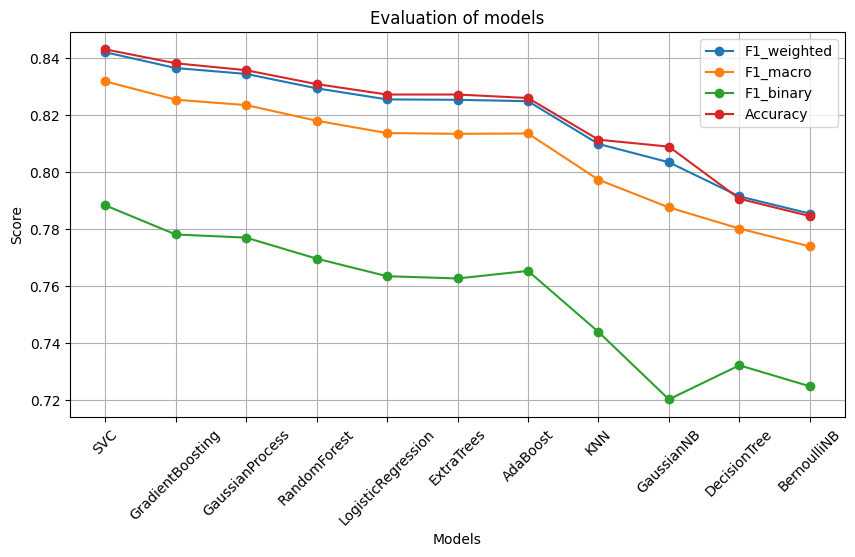

In [9]:
# Plot the benchmarking results
results_df.plot(
    figsize=(10, 5),
    title="Evaluation of models",
    xlabel="Models",
    ylabel="Score",
    xticks=results_df.index,
    grid=True,
    marker='o'
)

# Set x-axis as the models name
plt.xticks(ticks=results_df.index, labels=results_df['Model'], rotation=45)
plt.show()


## 6. Hyperparameter Tuning
Given the close performance of the top models, hyperparameter optimization was limited to the strongest and most diverse candidates (SVC, Gradient Boosting and Random Forest), balancing performance gains with model interpretability and computational cost.

#### Grid Search CV:

In [ ]:
"""
Hyperparameter tune Three best candidates to see whether they provide better performance.
* Using GridSearchCV
* Models to be tuned:
    - SVC
    - Gradient Boosting
    - Random Forest
"""

# Three final model candidates
candidates = ["SVC", "GradientBoosting", "RandomForest"]

# Define actual model objects
model_objects = {
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE)
}

# Set search space and hyperparameters for the chosen models
#-------------------------------------------------------------

models_hyperparams = {
    # SVC hyperparameters
    "SVC": {
        "clf__C": [0.01, 0.1, 1, 10, 100],
        "clf__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        "clf__class_weight": [None, "balanced"],
        #"clf__kernel": ["rbf", "linear"]
    },

    # GradientBoosting hyperparameters
    "GradientBoosting": {
        "clf__n_estimators": [100, 200, 300],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [2, 3, 4],
        "clf__subsample": [0.8, 1.0],
        #"clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 3, 5]
    },

    # RandomForest hyperparameters
    "RandomForest": {
        "clf__n_estimators": [200, 400, 600],
        "clf__max_depth": [None, 10, 20, 30],
        #"clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2"],
        "clf__class_weight": [None, "balanced"]
    }
}


# Define search methods, fit and print the results
#----------------------------------------------------
for name in candidates:
    pipe = Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", model_objects[name])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=models_hyperparams[name],
        cv=3,
        scoring="f1_weighted",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    print(f"\n{name}")
    print("Best params:", grid.best_params_)
    print("Best CV score:", grid.best_score_)






SVC
Best params: {'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 'auto'}
Best CV score: 0.8267341849683746

GradientBoosting
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__n_estimators': 300, 'clf__subsample': 1.0}
Best CV score: 0.8283323302414622

RandomForest
Best params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 600}
Best CV score: 0.8240396550945929


#### Randomized Search CV:

In [15]:
"""
Hyperparameter tune Three best candidates to see whether they provide better performance.
* Using RandomizedSearchCV
* Models to be tuned:
    - SVC
    - Gradient Boosting
    - Random Forest
"""

# Three final model candidates
candidates = ["SVC", "GradientBoosting", "RandomForest"]

# Define actual model objects
model_objects = {
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE)
}

# Set search space and hyperparameters for the chosen models
#-------------------------------------------------------------

models_hyperparams = {
    # SVC hyperparameters
    "SVC": {
        "clf__C": [0.25, 0.5, 0.75],
        "clf__gamma": ["scale", "auto"],
        "clf__class_weight": [None, "balanced"],
        #"clf__kernel": ["rbf", "linear"]
    },

    # GradientBoosting hyperparameters
    "GradientBoosting": {
        "clf__n_estimators": [225, 250, 275],
        "clf__learning_rate": [0.01, 0.02, 0.03],
        "clf__max_depth": [3, 4],
        "clf__subsample": [0.8, 0.9, 1.0],
        #"clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 3, 5]
    },

    # RandomForest hyperparameters
    "RandomForest": {
        "clf__n_estimators": [700, 800, 900],
        "clf__max_depth": [7, 8, 9],
        #"clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2"],
    }
}


# Define search methods, fit and print the results
#----------------------------------------------------
for name in candidates:
    pipe = Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", model_objects[name])
    ])

    randomized = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=models_hyperparams[name],
        cv=5,
        n_iter=10,
        random_state=RANDOM_STATE,
        scoring="f1_weighted",
        n_jobs=-1
    )

    randomized.fit(X_train, y_train)

    print(f"\n{name}")
    print("Best params:", randomized.best_params_)
    print("Best CV score:", randomized.best_score_)






SVC
Best params: {'clf__gamma': 'scale', 'clf__class_weight': None, 'clf__C': 0.5}
Best CV score: 0.8252039029074048

GradientBoosting
Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 275, 'clf__max_depth': 3, 'clf__learning_rate': 0.03}
Best CV score: 0.8244162153329793

RandomForest
Best params: {'clf__n_estimators': 700, 'clf__max_features': 'sqrt', 'clf__max_depth': 7}
Best CV score: 0.8250153199380753


## 8. The final best model
Despite extensive hyperparameter tuning using GridSearchCV and RandomizedSearchCV, no statistically significant improvement over default model configurations was observed. This suggests that model performance is primarily limited by data characteristics rather than model complexity. Therefore, the SVC model, which demonstrated the highest and most stable cross-validation performance, was selected as the final model. 

After selecting the best-performing model (SVC), the final training is performed using the original training dataset obtained after the initial train–test split (i.e., before splitting into training and validation subsets). At this stage, the validation set has already served its purpose for model selection and hyperparameter tuning, so all available training data is used to maximize learning. The test set remains completely untouched and is reserved exclusively for the final evaluation.


In [21]:
"""
Train the final best model on the full data we have.
"""

RANDOM_STATE = 42

# Detemine target and features
features = data.drop(columns=["Diagnosis"], errors="ignore")   # Features
label = data["Diagnosis"]   # Target/Label

# Define and set the model
svc = SVC(
    C=0.5,
    gamma="scale",
    class_weight=None,
    probability=True,
    random_state=RANDOM_STATE
)

# Perprocess
pipe = Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", svc)
    ])

# Fit and train
svc_model = pipe.fit(features, label)

# Save the trained model
joblib.dump(svc_model, "../Models/ML-Classification/ML-Cls-svc-model.pkl")



['../Models/ML-Classification/ML-Cls-svc-model.pkl']

## 9. Final evaluation

SVC Classifier Model:
F1-Score (weighted): 82.23 %
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       604
           1       0.83      0.72      0.77       423

    accuracy                           0.82      1027
   macro avg       0.83      0.81      0.81      1027
weighted avg       0.83      0.82      0.82      1027



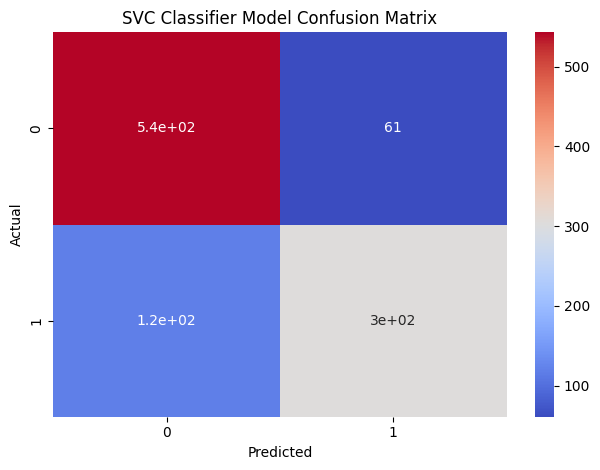

In [22]:
"""
Use test set to evaluate the model further
* NOTE: The model already is the full pipeline (pipeline + Tuned SVC) so there's no need to preprocess the test set!
"""

# Reload the model
MODEL = joblib.load("../Models/ML-Classification/ML-Cls-svc-model.pkl")

# Detemine target and features
test_features = test.drop(columns=["Diagnosis"], errors="ignore")   # Features
test_label = test["Diagnosis"]   # Target/Label

# Predict
test_predict = MODEL.predict(test_features)

#----- Evaluate -----
print("SVC Classifier Model:")
# F1-score
print(f"F1-Score (weighted): {round(f1_score(test_label, test_predict, average='weighted') * 100, 3)} %")
# Classification report
print(f"Classification Report:\n{classification_report(test_label, test_predict)}")
# Confusion matrix
svc_cm = confusion_matrix(test_label, test_predict)


# Visualize Confusion Matrix of SVC classifier Model
sns.heatmap(svc_cm, annot=True, cmap='coolwarm')
plt.title("SVC Classifier Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

